In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from faster_rcnn.utils.datasets.voc.voc import VOCDetection
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from faster_rcnn.utils.datasets.data_generator import CocoGenerator
from faster_rcnn.utils.datasets.data_generator import Enqueuer
from torch.optim import SGD, RMSprop, Adam

from faster_rcnn.faster_rcnn import FasterRCNN, RPN
from pycrayon import CrayonClient
import torch
from torch.optim.lr_scheduler import StepLR
from datetime import datetime
from PIL import Image, ImageDraw, ImageFont


/data
/data/data/mscoco


In [3]:
root = '/data'
ds = VOCDetection(root, 'train')
print(len(ds))

32832


In [4]:
def imshow(inp, gt_boxes=[], predict_boxes = []):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig,ax = plt.subplots(1, figsize=(20, 10))

    ax.imshow(inp)
    for i, box in enumerate(gt_boxes):
        print(box)
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1]  ,linewidth=2,edgecolor='r',facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
        
    for i, box in enumerate(predict_boxes):
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1]  ,linewidth=1,edgecolor='g',facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.pause(0.001)  # pause a bit so that plots are updated


In [5]:
data_gen = CocoGenerator(data=ds, batch_size=1, shuffle=True, seed=22)
queue = Enqueuer(generator=data_gen, use_multiprocessing=False)
queue.start(max_queue_size=20, workers=4)


[ 133.71428571  102.85714286  286.28571429  240.        ]


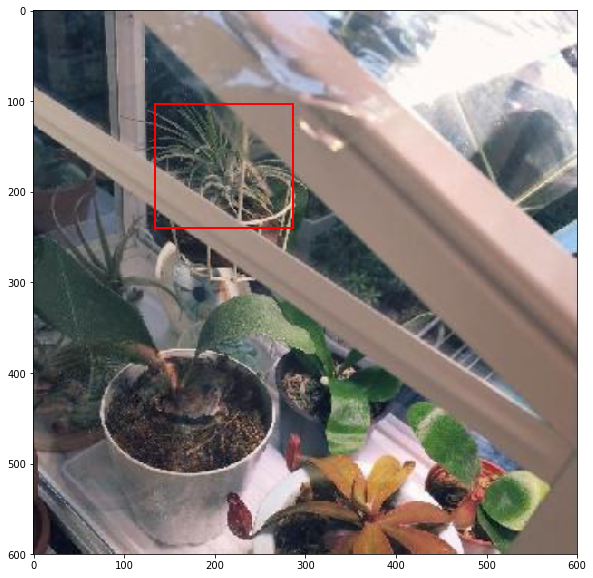

In [23]:
t = queue.get()
blobs = t.next()
gt_boxes = blobs['boxes']
gt_classes = blobs['gt_classes']
imshow(blobs['tensor'][0], gt_boxes)

In [24]:
val_ds = VOCDetection(root, 'val')
val_data_gen = CocoGenerator(data=val_ds, batch_size=1, shuffle=True, seed=22)
val_queue = Enqueuer(generator=data_gen, use_multiprocessing=False)
val_queue.start(max_queue_size=10,workers=4)
t2 = val_queue.get()

In [25]:
categories = ds.classes
print(categories)

['__background__', u'666', u'1077', u'1017', u'1506', u'723', u'1028', u'746', u'197', u'276', u'62412', u'671', u'80', u'1405', u'741', u'867', u'650', u'7141', u'400', u'1217', u'1027', u'1258', u'1529', u'593', u'150', u'543', u'1133', u'752', u'616', u'37', u'788', u'1166', u'1143', u'1221', u'1173', u'193', u'1249', u'810', u'722', u'255', u'742', u'121', u'755', u'3', u'200', u'236', u'13303', u'100', u'302', u'1185', u'1022', u'792', u'1439', u'10007', u'1236', u'332', u'782', u'1868', u'6397', u'1101', u'360', u'1251', u'277', u'866', u'538', u'339', u'1065', u'2053', u'75', u'15', u'269', u'1134', u'872', u'1064', u'1647', u'92', u'41', u'227', u'226', u'10970', u'1423', u'1243', u'791', u'59', u'12071', u'683', u'1058', u'245', u'1247', u'145', u'160', u'1560', u'62420', u'1009', u'324', u'491', u'1253', u'290', u'10077', u'93_leaf', u'93_fruit', u'93_flower', u'267', u'803', u'136', u'50', u'766', u'14979', u'1585', u'61', u'119', u'38', u'575', u'511', u'824', u'224', u'110

In [26]:
net = FasterRCNN(categories, debug=False)
net.cuda()
net.train()

FasterRCNN(
  (roi_pool): RoIPool(
  )
  (fc6): FC(
    (fc): Linear(in_features=25088, out_features=4096)
    (relu): ReLU(inplace)
  )
  (fc7): FC(
    (fc): Linear(in_features=4096, out_features=4096)
    (relu): ReLU(inplace)
  )
  (score_fc): FC(
    (fc): Linear(in_features=4096, out_features=164)
  )
  (bbox_fc): FC(
    (fc): Linear(in_features=4096, out_features=656)
  )
  (rpn): RPN(
    (features): Sequential(
      (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
      (5): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace)
      (7): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace)
      (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
      (10): Con

In [27]:
params = filter(lambda x: x.requires_grad, net.parameters())

In [37]:
def eval(data_gen ,model, epochs):
    model.train()
    val_loss = 0

    for epoch in range(epochs):
        try:
            blobs = data_gen.next()
            im_data = blobs['tensor']
            im_info = blobs['im_info']
            gt_boxes = blobs['boxes']
            gt_classes = blobs['gt_classes']
            gt_boxes = np.hstack([gt_boxes , gt_classes[:, np.newaxis]])
            cls_prob, bbox_pred, rois = model(im_data, im_info, gt_boxes)
        except Exception as e:
            print e
            continue

        loss = model.loss
        val_loss += loss.data[0]

    return val_loss / epochs

def train(data_gen, val_data_gen, optimizer, lr_scheduler ,model, epochs, steps_per_epoch):
    exp_name = datetime.now().strftime('vgg16_%m-%d_%H-%M')
    cc = CrayonClient(hostname="crayon", port=8889)
    exp = cc.create_experiment(exp_name)
    model.train()
    train_loss = 0

    for epoch in range(epochs):
        for step in range(1, steps_per_epoch +1):
            lr_scheduler.step()
            try:
                blobs = data_gen.next()
                im_data = blobs['tensor']
                im_info = blobs['im_info']
                gt_boxes = blobs['boxes']
                gt_classes = blobs['gt_classes']
#                 imshow(blobs['tensor'][0], gt_boxes)
                gt_boxes = np.hstack([gt_boxes , gt_classes[:, np.newaxis]])
                cls_prob, bbox_pred, rois = model(im_data, im_info, gt_boxes)
            except Exception as e:
                print e
                continue
                
            loss = model.loss
            train_loss += loss.data[0]
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if step % 100 == 0:
                log_text = 'step %d, image: %s, loss: %.4f' % (
                    step, blobs['im_name'], train_loss /(step))
                print(log_text)

                re_cnt = True

            if step % 10 == 0:
                exp.add_scalar_value('train_loss', train_loss / step, step=step)

            if step % 10000 == 0:
                torch.save(model.state_dict(), 'model_at_step_%s.pkl' % step)

In [31]:
optimizer = SGD(params, lr=1e-4, momentum=0.9, weight_decay=0.0005)
exp_lr_scheduler = StepLR(optimizer, step_size=1000, gamma=0.8)

In [32]:
train(t, t2, optimizer=optimizer,lr_scheduler=exp_lr_scheduler, model=net, epochs=1, steps_per_epoch=100000)

step 100, image: 1504970476506_thum_1504970476082_thum_sample.jpg, loss: 3.6114
step 200, image: 1501548101486_thum_1501548101104_thum_photo.jpg, loss: 3.4729
step 300, image: 1468103400239_thum_1468103399863_thum_sample.jpg, loss: 3.4709
step 400, image: 1492943909341_thum_1492943908719_thum_photo.jpg, loss: 3.4427
step 500, image: 1509696340203_thum_1509696339860_thum_sample.jpg, loss: 3.4371
step 600, image: 1477823088619_thum_1477823088330_thum_sample.jpg, loss: 3.4220
step 700, image: 1470624650466_thum_1470624650069_thum_tmp.jpg, loss: 3.3949
step 800, image: 1509930611435_thum_1509930610441_thum_photo.jpg, loss: 3.3830
step 900, image: 1466304053347_thum_1466304053023_thum_sample.jpg, loss: 3.3570
step 1000, image: 1502525589108_thum_1502525588414_thum_photo.jpg, loss: 3.3174
step 1100, image: 1495196535319_thum_1495196534436_thum_photo.jpg, loss: 3.3016
step 1200, image: 1496315516275_thum_1496315515643_thum_photo.jpg, loss: 3.2991
step 1300, image: 1495204097799_thum_149520409

faster_rcnn/fastrcnn/bbox_transform.py:35: RuntimeWarning: invalid value encountered in log
  targets_dw = np.log(gt_widths / ex_widths)


the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
step 7000, image: 1498091716346_thum_1498091715736_thum_photo.jpg, loss: 3.0572
step 7100, image: 1500167075867_thum_1500167075275_thum_photo.jpg, loss: 3.0555
step 7200, image: 1507501403573_thum_1507501403225_thum_sample.jpg, loss: 3.0539
step 7300, image: 1502438070032_thum_1502438069742_thum_sample.jpg, loss: 3.0529
step 7400, image: 1505917380860_thum_1505917380143_thum_photo.jpg, loss: 3.0512
step 7500, image: 1503192972628_thum_1503192971993_thum_photo.jpg, loss: 3.0515
step 7600, image: 1469939238525_thum_1469939238194_thum_tmp.jpg, loss: 3.0482
step 7700, image: 1462665163876_thum_1462665163271_thum_tmp.jpg, loss: 3.0460
step 7800, image: 1511928463010_thum_1511928462426_thum_photo.jpg, loss: 3.0446
step 7900, image: 1514504446800_thum_1514504446316_thum_sample.jpg, loss: 3.0444
step 8000, image: 1492468837585_thum_1492468837226_thum_photo.jpg, loss: 3.0445
step 8100, image: 150

faster_rcnn/rpn_msr/proposal_layer.py:199: RuntimeWarning: invalid value encountered in greater_equal
  keep = np.where((ws >= min_size) & (hs >= min_size))[0]


the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch


the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch


the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch


the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
step 14700, image: 1507434851121_thum_1507434850439_thum_photo.jpg, loss: nan
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array 

KeyboardInterrupt: 

In [33]:
weights = torch.load('./model_at_step_10000.pkl')
net.load_state_dict(weights)

In [39]:
optimizer = SGD(params, lr=1e-5, momentum=0.9, weight_decay=0.0005)
exp_lr_scheduler = StepLR(optimizer, step_size=1000, gamma=0.92)

In [ ]:
train(t, t2, optimizer=optimizer,lr_scheduler=exp_lr_scheduler, model=net, epochs=1, steps_per_epoch=100000)

step 100, image: 1514096014683_thum_1514096014306_thum_sample.jpg, loss: 2.9592
step 200, image: 1493168527500_thum_1493168527106_thum_photo.jpg, loss: 2.9698
step 300, image: 1514194356198_thum_1514194355670_thum_photo.jpg, loss: 2.9609
step 400, image: 1514672563727_thum_1514672562957_thum_photo.jpg, loss: 2.9318
step 500, image: 1507109748595_thum_1507109747657_thum_photo.jpg, loss: 2.9130
step 600, image: 1479540423579_thum_1479540423178_thum_tmp.jpg, loss: 2.9150
step 700, image: 1511048597790_thum_1511048597131_thum_sample.jpg, loss: 2.9110
step 800, image: 1496711066468_thum_1496711066027_thum_sample.jpg, loss: 2.9089
step 900, image: 1499050025192_thum_1499050024714_thum_photo.jpg, loss: 2.9118
step 1000, image: 1504176120498_thum_1504176119809_thum_photo.jpg, loss: 2.9103
step 1100, image: 1474681962371_thum_1474681961726_thum_tmp.jpg, loss: 2.9190
step 1200, image: 3e6e8a63-afd6-11e6-869f-00909a9fa1eb.jpg, loss: 2.9249
step 1300, image: 1496528429987_thum_1496528429555_thum_p

step 10400, image: 1496275916124_thum_1496275915433_thum_photo.jpg, loss: 2.9074
step 10500, image: 1501506517820_thum_1501506517423_thum_photo.jpg, loss: 2.9075
step 10600, image: 1508421869773_thum_1508421869255_thum_photo.jpg, loss: 2.9069
step 10700, image: 1494537922730_thum_1494537922217_thum_photo.jpg, loss: 2.9068
step 10800, image: 1476527269324_thum_1476527268853_thum_tmp.jpg, loss: 2.9065
step 10900, image: 1511907354970_thum_1511907354401_thum_photo.jpg, loss: 2.9060
step 11000, image: 1508656834887_thum_1508656834298_thum_photo.jpg, loss: 2.9061
step 11100, image: 1513036910923_thum_1513036910375_thum_photo.jpg, loss: 2.9063
step 11200, image: 1510482672843_thum_1510482672046_thum_photo.jpg, loss: 2.9066
step 11300, image: 1461479017040_thum_1461479016612_thum_tmp.jpg, loss: 2.9067
step 11400, image: 1495368572998_thum_1495368572435_thum_sample.jpg, loss: 2.9063
step 11500, image: 1495265369281_thum_1495265368759_thum_sample.jpg, loss: 2.9061
step 11600, image: 14641272764

the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
step 13500, image: 1498197729676_thum_1498197728996_thum_photo.jpg, loss: nan
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array 

the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
step 14400, image: 1496275191005_thum_1496275190461_thum_photo.jpg, loss: nan
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array 

the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
step 15200, image: 1500281386854_thum_1500281386391_thum_photo.jpg, loss: nan
the given numpy array 

the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
step 15900, image: 1509423739117_thum_1509423738675_thum_sample.jpg, loss: nan
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array

the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
step 16700, image: 1505719791377_thum_1505719790950_thum_sample.jpg, loss: nan
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array

the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
step 17400, image: 1503616574277_thum_1503616573861_thum_sample.jpg, loss: nan
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array

the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
step 18100, image: 25739388984_60fdfd556d.jpg, loss: nan
the given numpy array has zero-sized dimens

the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch


the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
step 19600, image: 66db7e96-9ae9-4a38-b196-16d2efc152dd.jpg, loss: nan
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zer

the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch


the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
step 21100, image: 1514851444154_thum_1514851443533_thum_sample.jpg, loss: nan
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array

the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
step 22000, image: 1505721932695_thum_1505721931991_thum_photo.jpg, loss: nan
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array 

the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch


the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
step 23400, image: 1462055127957_thum_1462055127486_thum_tmp.jpg, loss: nan
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array ha

the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
step 24100, image: 1480824161337_thum_1480824160958_thum_sample.jpg, loss: nan
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
step 24200, image: 14

the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch


the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch


step 26300, image: 1498029138372_thum_1498029137973_thum_photo.jpg, loss: nan
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array 

the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
step 27100, image: 1512262543388_thum_1512262542983_thum_sample.jpg, loss: nan
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array

the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
step 28000, image: 1505085561841_thum_1505085561473_thum_sample.jpg, loss: nan
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array

the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch


the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch


the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
step 30200, image: 1504477850119_thum_1504477849452_thum_photo.jpg, loss: nan
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array 

the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
step 30900, image: 1508207150747_thum_1508207149747_thum_photo.jpg, loss: nan
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
step 31000, image: 151

the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
step 31800, image: 1499867710351_thum_1499867709887_thum_photo.jpg, loss: nan
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array 

step 32500, image: 1494802413371_thum_1494802413011_thum_sample.jpg, loss: nan
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array

the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
step 33200, image: 1472217521127_thum_1472217520706_thum_tmp.jpg, loss: nan
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array ha

the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
step 33900, image: 1503815163937_thum_1503815163385_thum_photo.jpg, loss: nan
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array 

the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
step 34600, image: 1503659928783_thum_1503659928217_thum_photo.jpg, loss: nan
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array 

the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch


the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
step 36200, image: 1499918089514_thum_1499918089218_thum_sample.jpg, loss: nan
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array

the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch


the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
step 37700, image: 1512642772364_thum_1512642771754_thum_photo.jpg, loss: nan
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array 

the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
step 38400, image: 1470387873629_thum_1470387873292_thum_sample.jpg, loss: nan
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array

the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
step 39000, image: 1498778187080_thum_1498778186660_thum_photo.jpg, loss: nan
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array 

the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch


step 40400, image: 1509024703101_thum_1509024702743_thum_sample.jpg, loss: nan
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array

step 41200, image: 1500165168053_thum_1500165167481_thum_sample.jpg, loss: nan
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
step 41300, image: 1477455900607_thum_1477455900155_thum_tmp.jpg, loss: nan
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensio

the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
step 42200, image: 1494474302018_thum_1494474301430_thum_photo.jpg, loss: nan
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
the given numpy array 

the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch
step 42900, image: 1499525664884_thum_1499525664056_thum_photo.jpg, loss: nan


KeyboardInterrupt: 

ERROR:tornado.general:Uncaught exception, closing connection.
Traceback (most recent call last):
  File "/opt/conda/envs/pytorch/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/opt/conda/envs/pytorch/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/envs/pytorch/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 281, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/opt/conda/envs/pytorch/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 232, in dispatch_shell
    handler(stream, idents, msg)
  File "/opt/conda/envs/pytorch/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 419, in execute_request
    self._abort_queues()
  File "/opt/conda/envs/pytorch/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 634, in _abort_queues
    self._abort_queue(stream)
  File "/opt/conda/envs/pytor

In [ ]:
torch.save(net.state_dict(), 'erros.pkl' )

In [ ]:
def result_show(inp, predicted_boxes=[], classes=[], scores=[]):
    font = ImageFont.truetype(font ='./font/FiraMono-Medium.otf', size=np.floor(3e-2 * 600 + 0.5).astype('int32'))
    
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    inp *= 255.0/inp.max() 
    
    fig,ax = plt.subplots(1, figsize=(20, 10))
    
    image = Image.fromarray(inp.astype('uint8'))
    
    draw = ImageDraw.Draw(image)
    for predicted_box, predicted_class, score in zip(predicted_boxes, classes, scores):
        label = '{} {:.2f}'.format(predicted_class, score)

        
        label_size = draw.textsize(label, font)
        
        left, top, right, bottom = predicted_box
        print(predicted_class, (left, top), (right, bottom))
        
        for i in range(3):
            draw.rectangle(
                [left + i, top + i, right - i, bottom - i],
                outline=(255,255,0))
        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])
        draw.rectangle(
                [tuple(text_origin), tuple(text_origin + label_size)])
        draw.text(text_origin, label, fill=(255, 255, 0), font=font)
    del draw
    ax.imshow(image)

In [ ]:
pred_boxes, scores, classes, rois, blob = net.detect('./test_im/1501656556434_thum_1501656555444_thum_photo.jpg', thr=0.00)


In [ ]:
print pred_boxes

In [ ]:
print scores

In [ ]:
print classes

In [ ]:
print rois
